# Case study
# Impact van de ERBB2 N857S mutatie bij eierstokkanker
**Auteur:** Manon Barelds
**Datum:** 19 december 2025
**Cursus:** Modelleren van kanker, bio-informatica, Hanzehogeschool Groningen



## _Introductie_

Kanker is vaak het gevolg van genetische mutaties die leiden tot veranderingen in de structuur en dynamiek van eiwitten die betrokken zijn bij cellulaire signaaltransductie. Receptor-tyrosinekinasen spelen hierin een centrale rol, omdat zij groei- en overlevingssignalen reguleren. Eén van deze eiwitten is ERBB2 (HER2), een receptor-tyrosinekinase dat frequent geassocieerd wordt met verschillende vormen van kanker, waaronder eierstokkanker ("https://www.mycancergenome.org/content/gene/erbb2/").

In dit notebook wordt het kinasedomein van ERBB2 bestudeerd, met specifieke aandacht voor een oncogene puntmutatie (N857S) waarbij het aminozuur asparagine (N) is vervangen door serine (S) op positie 857. Deze mutatie bevindt zich in een functioneel belangrijk gebied van het kinasedomein en kan de eiwitstructuur, dynamiek en functie beïnvloeden. Dergelijke veranderingen kunnen leiden tot abnormale activatie van signaalroutes die bijdragen aan tumorvorming en resistentie tegen gerichte therapieën.

Het doel van deze notebook is om de relatie tussen eiwitstructuur, dynamiek en (dys)functie te onderzoeken door middel van computationele modellering en simulatie. Eerst worden zowel het wild-type als de gemuteerde ERBB2-structuur voorspeld met AlphaFold. Vervolgens worden molecular dynamics (MD) simulaties uitgevoerd met GROMACS om verschillen in stabiliteit, flexibiliteit en conformationele veranderingen te analyseren. De resulterende structuren worden gevisualiseerd met PyMOL en kwantitatief geanalyseerd door middel van RMSD-anaylse, RMSF-analyse en PCA.

Door een vergelijkende analyse van wild-type en mutant wordt onderzocht hoe de N857S-mutatie de dynamiek van het kinasedomein beïnvloedt en welke functionele consequenties dit kan hebben.

Dit alles om antwoord te geven op de vraag;
Hoe beïnvloedt de N857S-mutatie in het kinasedomein van ERBB2 de structuur en dynamiek van het eiwit, en wat zijn de mogelijke implicaties voor oncogene activatie en gerichte therapie bij eierstokkanker?


## Modelleren met Alphafold en Gromacs

### _Doel van deze stap_
Het voorspellen van de driedimensionale structuren van het wild-type ERBB2-
kinasedomein en de N857S-mutant met AlphaFold, en het voorbereiden van deze
structuren voor molecular dynamics (MD) simulaties met GROMACS.

Voor deze case study is het kinasedomein van ERBB2 geselecteerd (residuen 720–987).
De wild-type sequentie is verkregen uit UniProt (P04626). De onderzochte mutatie,
N857S, is een oncogene variant die volgens UniProt (VAR_042099) geassocieerd is met
eierstokkanker.

Eierstokkanker wordt vaak in een laat stadium gediagnosticeerd vanwege aspecifieke
vroege symptomen, wat de prognose negatief beïnvloedt ("https://www.kwf.nl/eierstokkanker"). Vanwege de klinische relevantie
van ERBB2 en de onderbelichting van vrouw-specifieke aandoeningen in biomedisch
onderzoek, is deze mutatie geselecteerd voor analyse.

### _Genereren van wild-type en gemuteerde FASTA-sequenties_

Voor de AlphaFold-voorspelling zijn FASTA-bestanden nodig van zowel het wild-type
ERBB2-kinasedomein als de N857S-mutant. De N857S-mutatie bevindt zich op positie 857
in het volledige ERBB2-eiwit, wat overeenkomt met residu 138 in de geselecteerde
kinasedomeinsequentie (residuen 720–987).

In de Python-code wordt hiervoor index 137 gebruikt, aangezien Python 0-gebaseerde
indexering hanteert. De aanwezigheid van asparagine (N) op deze positie in de
wild-type sequentie wordt gecontroleerd voordat de mutatie wordt toegepast.


In [1]:
# Bestandsnamen
input_txt = "Kinase_ERBB2.txt"
fasta_original = "ERBB2_kinase_original.fasta"
fasta_mutated = "ERBB2_kinase_mutated.fasta"

# Mutatie parameters
mutatie_positie_eiwit = 857   # 1-gebaseerd, volledige ERBB2-eiwit
fragment_start = 720          # startpositie van fragment in eiwit (1-gebaseerd)
origineel_zuur = "N"
nieuw_zuur = "S"

# Lees sequentie
with open(input_txt, "r") as f:
    sequence = f.read().replace("\n", "").strip()

# Bepaal mutatie-index
# Omrekening van eiwitpositie (1-gebaseerd) naar Python-index (0-gebaseerd)
mutatie_index = mutatie_positie_eiwit - fragment_start

# Veiligheidscheck
if not (0 <= mutatie_index < len(sequence)):
    raise ValueError("Mutatiepositie ligt buiten de sequentie.")

# Controleer of het verwachte aminozuur aanwezig is
assert sequence[mutatie_index] == origineel_zuur, (
    f"Verwacht '{origineel_zuur}' op positie {mutatie_positie_eiwit}, "
    f"maar vond '{sequence[mutatie_index]}'"
)

# Schrijf wild-type FASTA
with open(fasta_original, "w") as f:
    f.write(">ERBB2_kinase_720-987_wildtype\n")
    for i in range(0, len(sequence), 60):
        f.write(sequence[i:i+60] + "\n")

# Pas mutatie toe
mutated_sequence = (
    sequence[:mutatie_index] +
    nieuw_zuur +
    sequence[mutatie_index + 1:]
)

# Schrijf gemuteerde FASTA
with open(fasta_mutated, "w") as f:
    f.write(">ERBB2_kinase_720-987_N857S\n")
    for i in range(0, len(mutated_sequence), 60):
        f.write(mutated_sequence[i:i+60] + "\n")

#Rapportage
print("FASTA-bestanden succesvol aangemaakt:")
print(f"- Wild-type: {fasta_original}")
print(f"- N857S mutant: {fasta_mutated}")
print(
    f"Mutatie toegepast op residu {mutatie_positie_eiwit} "
    f"(index {mutatie_index} in fragmentsequentie)."
)


FASTA-bestanden succesvol aangemaakt:
- Wild-type: ERBB2_kinase_original.fasta
- N857S mutant: ERBB2_kinase_mutated.fasta
Mutatie toegepast op residu 857 (index 137 in fragmentsequentie).


### _Structuurvoorspelling met AlphaFold_
De structuren van zowel het wild-type als de N857S-mutant van het ERBB2-kinasedomein zijn voorspeld met AlphaFold.

AlphaFold-voorspellingen

![AlphaFold ERBB2 wild-type](AlphaFold_ERBB2_wild-type.png)







![AlphaFold ERBB2 N857S-mutant](AlphaFold_ERBB2_N857S-mutant.png)






Voor zowel het wild-type als het gemuteerde ERBB2-kinasedomein is een pTM-score van 0.92 verkregen, wat wijst op een zeer hoge globale structurele betrouwbaarheid van de AlphaFold-voorspellingen. Daarnaast hebben de meeste residuen een hoge pLDDT-score (>90), wat aangeeft dat AlphaFold zeer zeker is over de lokale structuur en de algemene vouwing van beide eiwitten. De pLDDT score staat voor de predicted local distance difference test. Het is een per-residue maat voor lokale betrouwbaarheid. De score loopt van 0 tot 100, waarbij hogere scores een hogere betrouwbaarheid en doorgaans een nauwkeurigere voorspelling aangeven ("https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/plddt-understanding-local-confidence/").

In beide structuren is het grootste deel van het eiwit donkerblauw gekleurd, wat overeenkomt met een hoge betrouwbaarheid. Lagere pLDDT-scores (geel/oranje) komen voornamelijk voor in lusregio’s of flexibele delen aan het oppervlak van het eiwit, wat biologisch verwacht is.

De globale vouwing van het kinasedomein is sterk vergelijkbaar tussen het wild-type en de gemuteerde variant. De mutatie lijkt dan ook geen grootschalige structurele verstoring te veroorzaken.

De PAE-matrices zijn voor beide structuren grotendeels donkergroen, wat duidt op een lage verwachte positionele fout tussen residuen. Dit suggereert dat de relatieve positionering van de structurele elementen in beide modellen betrouwbaar is. De PAE is een maatstaf voor hoe zeker AlphaFold is van de relatieve positie van twee residuen binnen de voorspelde structuur.PAE wordt gedefinieerd als de verwachte positionele fout bij residu X, gemeten in Ångström (Å), als de voorspelde en werkelijke structuren zouden worden uitgelijnd op residu Y ("https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/pae-a-measure-of-global-confidence-in-alphafold-predictions/").

Hoewel de globale structuur behouden blijft, kunnen lokale structurele veranderingen door de mutatie mogelijk invloed hebben op de functie van het kinasedomein.

### _GROMACS_
Voor beide varianten zijn vijf modellen gegenereerd door AlphaFold in CIF-formaat. Deze modellen zijn doorgestuurd naar T.Wassenaar voor de moleculaire dynamica-simulatie met behulp van het Linux/Bash-script GROMIT (https://www.github.com/Tsjerk/gromit/
). Hierbij is gebruikgemaakt van het amber99sb-ildn force field en een simulatieperiode van 100 nanoseconden. De simulatie is voorbereid tot net vóór de productierun, die op een GPU uitgevoerd moet worden, zodat verdere analyses kunnen worden uitgevoerd op de voorbereide simulatiebestanden.

Met behulp van GROMACS zijn moleculaire dynamica-simulaties uitgevoerd op deze modellen om inzicht te krijgen in de dynamische eigenschappen en stabiliteit van de eiwitten. Hierbij kunnen bewegingen en flexibiliteit van het eiwit op atomaire schaal worden onderzocht, en verschillen tussen het wild-type en de mutant worden geanalyseerd.

Deze voorbereidende stappen zorgen ervoor dat de structuren van zowel het wild-type als de N857S-mutant dynamisch kunnen worden geanalyseerd, zodat verschillen in stabiliteit, flexibiliteit en functionele bewegingen tussen de twee varianten inzichtelijk worden.

## Visualisatie van eiwitten en dynamica met PyMOL
## _Doel van deze stap_
 Het doel is het visualiseren van structurele verschillen en dynamische eigenschappen van het wild-type en gemuteerde ERBB2-kinasedomein.

De voorspelde structuren zijn gevisualiseerd in PyMOL om globale structurele verschillen te inspecteren. De code hieronder kun je opslaan als "naam".pml (een PyMol-bestand) en deze kun je in PyMol runnen.


```pml
# Laad structuren en trajecten
# In mijn voorbeeld
load "MB_A_whole.pdb", wild_type
load_traj "MB_A_whole.xtc", wild_type
load "MB_B_whole.pdb", mutant
load_traj "MB_B_whole.xtc", mutant

# Uitlijnen
intra_fit wild_type and name CA
intra_fit mutant and name CA
super mutant and name CA, wild_type and name CA

# Cartoon weergave voor eiwitten
hide everything
show cartoon, wild_type or mutant
color cyan, wild_type
color magenta, mutant

# Camera
set_view (\
     0.984463573,   -0.123165488,    0.125151560,\
     0.166112125,    0.884289622,   -0.436397702,\
    -0.056921422,    0.450405747,    0.891007483,\
     0.000000000,    0.000000000, -203.064926147,\
    65.139564514,   67.184852600,   31.021080017,\
   160.097930908,  246.031921387,  -20.000000000 )

# RMSD check
rms_cur mutant and name CA, wild_type and name CA

# Highlight mutatie met sticks
# Mutant residu 138 (N857S) (want 1 based)
show sticks, mutant and resi 138
color red, mutant and resi 138

# Wild type residu 138 (N857) voor vergelijking
show sticks, wild_type and resi 138
color blue, wild_type and resi 138

```

![Pymolbestand1](Pymolbestand1.png)

![Pymolbestand2](Pymolbestand2.png)

Hier kun je het wild-type ERBB2-kinasedomein zien in het licht blauw en de N857S-mutant-kinasedomein in het roze. De plek van de mutatie (residue plaats 857 of in alleen het kinasedomein plaats 137) duidelijk aangegeven met donkerblauw op het wild-type en rood op het mutant-type.





De volgende code is een PyMolbestand(.pml)
Sla deze code op als .pml bestand en run het script in Pymol. Je krijgt een aantal frames te zien die je kunt afspelen als 'filmpje' zo zie je hoe het wild-type kinasedomein en het N857S-mutant kinasedomein bewegen over een tijd van 100 ns.

```pml
# Laad structuren en trajecten
load "MB_A_whole.pdb", wild_type
load_traj "MB_A_whole.xtc", wild_type
load "MB_B_whole.pdb", mutant
load_traj "MB_B_whole.xtc", mutant

# Uitlijnen
intra_fit wil_type and name CA
intra_fit mutant and name CA
super mutant and name CA, wild_type and name CA

# Cartoon weergave voor eiwitten
hide everything
show cartoon, wild_type or mutant
color cyan, wild_type
color magenta, mutant

# Camera
set_view (\
     0.984463573,   -0.123165488,    0.125151560,\
     0.166112125,    0.884289622,   -0.436397702,\
    -0.056921422,    0.450405747,    0.891007483,\
     0.000000000,    0.000000000, -203.064926147,\
    65.139564514,   67.184852600,   31.021080017,\
   160.097930908,  246.031921387,  -20.000000000 )

# RMSD check
rms_cur mutant and name CA, wild_type and name CA

# Highlight mutatie met sticks
# Mutant residu 138 (N857S) (want 1 based)
show sticks, mutant and resi 138
color red, mutant and resi 138

# Wild type residu 138 (N857) voor vergelijking
show sticks, wild_type and resi 138
color blue, wild_type and resi 138

# Movie instellingen voor animatie in PyMOL
set movie_loop, 1

ray 1200, 1200
# Sla op als PNG
png Pymol_snapshot.png
```
NOTE Het duurt een poosje dus je moet even geduld hebben.

![Pymolbestand4](Pymolbestand4.png)

Hier zie je dat er veel frames worden gemaakt die je kunt afspelen.
Om een echt filmpje te maken moet je in de terminal naar het mapje frames gaan en dit runnen(windows).

```bash
& "C:\ffmpeg\ffmpeg-2025-12-18-git-78c75d546a-full_build\bin\ffmpeg.exe" -framerate 25 -start_number 0001 -i frame%04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -crf 18 -pix_fmt yuv420p visualisatie_wild_mutate.mp4
# "C:\ffmpeg\ffmpeg-2025-12-18-git-78c75d546a-full_build\bin\ffmpeg.exe" is pad naar ffmpeg.exe bestand (installeren ffmpeg vereist)
```




In [9]:
from IPython.display import Video

Video("frames/visualisatie_wild_mutate.mp4", embed=False)

"Over de tijd vertonen het wildtype en de N857S-mutant van het ERBB2-kinasedomein vergelijkbare globale structuren en dynamische patronen. Opvallend is dat enkele lussen afwijkend bewegen, met name de lus rechtsboven, terwijl de rest van het domein een sterk overeenkomstige beweging laat zien."

## Beschrijvende analyse

### _Doel van deze stap_
Het doel is Het kwantificeren van stabiliteit en dynamiek van het wild-type en de mutant aan de hand van beschrijvende statistieken.


#### python code
Hieronder zie je de python code die de RMSD en de RMSF berekend en plot van de wild-type en de N857S mutant. De bestanden die gebruikt worden zijn tot stand gekomen door gebruik te maken van GROMACS.


```bash
gmx rms -s Manon/A/A-MD.tpr -f MB_A_whole.xtc -o rmsdwild.xvg -tu ns (met groep 1 Protein)
gmx rms -s Manon/B/B-MD.tpr -f MB_B_whole.xtc -o rmsdmutant.xvg -tu ns (met groep 1 Protein)
gmx rmsf -s Manon/A/A-MD.tpr -f MB_A_whole.xtc -o rmsfwild.xvg -res (met groep 1 Protein)
gmx rmsf -s Manon/B/B-MD.tpr -f MB_B_whole.xtc -o rmsfmutant.xvg -res (met groep 1 Protein)

#.xtc is de trajectory, .tpr is de startstructuur, .xvg is het output bestand, Protein omdat je de analyse specifiek wilt richten op de beweging en stabiliteit van het eiwit zelf, en niet op de rest van de simulatieomgeving. Door consequent 'Protein' te kiezen, zorg je voor een zuivere, vergelijkbare analyse tussen je wild-type en de N857S-mutant.

```

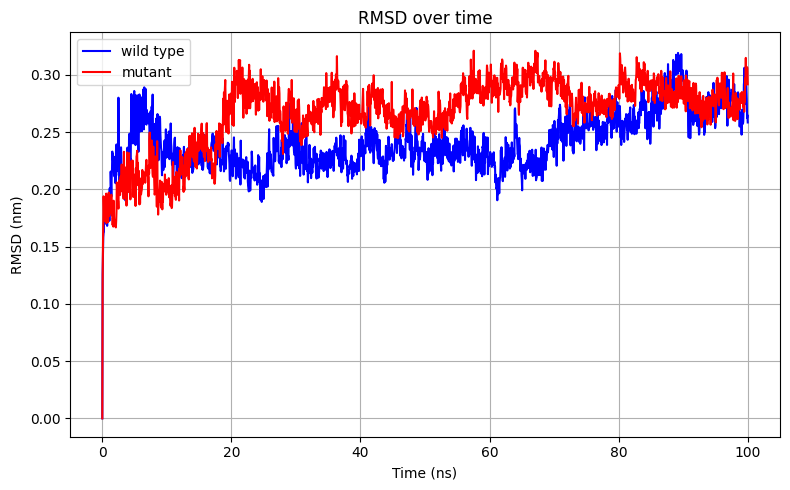

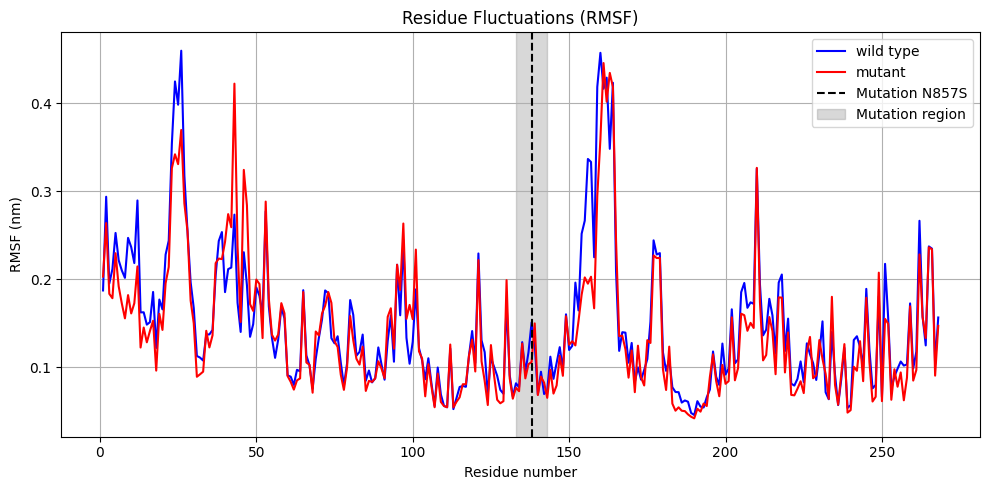

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Laad RMSD bestanden
rmsd_A_file = "rmsdwild.xvg"  # wild type
rmsd_B_file = "rmsdmutant.xvg"  # mutant

data_A = np.loadtxt(rmsd_A_file, comments=['@','#'])
data_B = np.loadtxt(rmsd_B_file, comments=['@','#'])

time_A = data_A[:,0]  # tijd (ns)
rmsd_A = data_A[:,1]  # RMSD

time_B = data_B[:,0]
rmsd_B = data_B[:,1]

# Plot RMSD
plt.figure(figsize=(8,5))
plt.plot(time_A, rmsd_A, label='wild type', color='blue')
plt.plot(time_B, rmsd_B, label='mutant', color='red')
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Laad RMSF bestanden
rmsf_A_file = "rmsfwild.xvg"
rmsf_B_file = "rmsfmutant.xvg"

data_A = np.loadtxt(rmsf_A_file, comments=['@','#'])
data_B = np.loadtxt(rmsf_B_file, comments=['@','#'])

residues = data_A[:,0]  # residunummers
rmsf_A = data_A[:,1]
rmsf_B = data_B[:,1]


# RMSF plot met mutatie-highlight
mutation_index = 138  # S857/N857 in .xvg nummering (1 based)

plt.figure(figsize=(10,5))

plt.plot(residues, rmsf_A, label='wild type', color='blue')
plt.plot(residues, rmsf_B, label='mutant', color='red')

# Verticale lijn op mutatie
plt.axvline(
    x=mutation_index,
    color='black',
    linestyle='--',
    linewidth=1.5,
    label='Mutation N857S'
)

# Gearceerde regio rond mutatie (±5 residuen)
plt.axvspan(
    mutation_index - 5,
    mutation_index + 5,
    color='grey',
    alpha=0.3,
    label='Mutation region'
)

plt.xlabel('Residue number')
plt.ylabel('RMSF (nm)')
plt.title('Residue Fluctuations (RMSF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### _RMSD-analyse_
RMSD (Root Mean Square Deviation) meet hoe ver de structuur van het eiwit afwijkt van de startconformatie tijdens de simulatie. RMSD geeft inzicht in de stabiliteit en dynamiek van het eiwit tijdens de simulatie.

Uit de grafiek blijkt dat beide systemen in de eerste paar nanoseconden snel stijgen in RMSD, waarna een relatief stabiel gebied wordt bereikt. Dit is typisch voor het equilibratie-stadium van een simulatie.

Vergelijking van het wild-type en de mutant laat zien dat de mutant over het algemeen een hogere RMSD (+/-0,27–0,30 nm) heeft dan het wild-type (+/-0,22–0,26 nm). Dit suggereert dat:
- de structuur van de mutant meer fluctueert,
- de mutant een grotere flexibiliteit heeft, of
- er mogelijk structurele veranderingen optreden.

Daarnaast kan dit erop wijzen dat de mutant minder stabiel is dan het wild-type.

#### _RMSF-analyse_
RMSF (Root Mean Square Fluctuation) meet de gemiddelde fluctuatie van individuele residuen gedurende de simulatie. Het geeft inzicht in welke delen van het eiwit flexibel zijn en welke juist relatief stabiel blijven.

In de grafiek is de blauwe lijn de RMSF van het wild-type eiwit, de rode lijn de RMSF van de mutant. De verticale stippellijn markeert het mutatieresidu (N857S), en het grijze gebied zorgt ervoor dat je oog naar de mutatie punt getrokken wordt.

Uit de grafiek blijkt dat beide eiwitten pieken en dalen in RMSF vertonen, wat wijst op gebieden van hoge flexibiliteit (pieken) en stabiele secundaire structuren (dalen).

In de buurt van de mutatieplek is te zien dat de RMSF van de mutant iets verschilt van het wild-type, wat kan wijzen op lokale veranderingen in flexibiliteit door de mutatie.

Buiten de mutatieplek vertonen de RMSF-profielen van wild-type en mutant grotendeels vergelijkbare patronen, wat suggereert dat de algemene structurele dynamiek van het eiwit grotendeels behouden blijft. Wel zie je dat tussen residue 0 en 30 de wild-type boven de mutant ligt qua pieken. Ook rond residue 160 zie je een verschil tussen de wild-type en mutant, de wild-type verschilt hier +/- 0.1 nm ten opzichte van de mutant. Rond residue 40 tot 55 ligt de mutant boven de wildtype. 


#### _PCA analyse_
Principal Component Analysis (PCA) is een statistische methode die wordt gebruikt om complexe datasets met veel variabelen te reduceren tot een kleiner aantal nieuwe variabelen, de principal components. Deze componenten zijn lineaire combinaties van de oorspronkelijke variabelen en zijn zo gekozen dat ze opeenvolgend zoveel mogelijk variantie in de data verklaren. De eerste hoofdcomponent (PC1) verklaart de meeste variantie. PCA is een unsupervised methode en wordt vaak gebruikt om patronen, structuur en verschillen in data inzichtelijk te maken.

Hieronder volgt de PML-code voor het uitvoeren van een PCA voor zowel het wild type als het mutant type. De PC1-scores (S1) worden opgeslagen om deze later te plotten in histogrammen. Daarnaast wordt een afbeelding van de PCA gegenereerd en opgeslagen, die hieronder wordt weergegeven.

```pml
# wild type
#LADEN EN VOORBEREIDEN wild type
load "MB_A_whole.pdb", wild_type
load_traj "MB_A_whole.xtc", wild_type
intra_fit wild_type and name CA
remove resn sol+na+cl+hydro

# PCA
import numpy as np
mdl = cmd.get_model("wild_type")
X = np.array([ cmd.get_model("wild_type", state=idx+1).get_coord_list() for idx in range (cmd.count_states("wild_type"))])
mean = X.mean(axis=0)
X = (X - mean).reshape((len(X), -1))
vals, vecs = np.linalg.eigh(X @ (X.T / len(X)))
loadings = X.T @ vecs[:, ::-1]
loadings /= (loadings**2).sum(axis=0, keepdims=True)**0.5
scores = X @ loadings
L1 = loadings[:, 0].reshape((-1, 3))
S1 = scores[:, 0]
xmin = S1.min() * L1 + mean
xmax = S1.max() * L1 + mean

# Tekenen van de cilinders per atoom (Blauw naar Rood verloop)
cmd.load_cgo([u for (xs, ys, zs), (xe, ye, ze) in zip(xmin, xmax) for u in [9.0, xs, ys, zs, xe, ye, ze, 0.1, 0, 0, 1, 1, 0, 0]], "pc1_wt")

M= cmd.get_model("wild_type")
for idx, mx in enumerate(mean): M.atom[idx].coord = list(mx)
cmd.load_model(M, 'mean')

show sticks, wild_type and resi 138
color orange, wild_type and resi 138
set stick_radius, 0.3
label wild_type and resi 138 and name CA, "Residue 138 (WT)"

np.savetxt("PC1_wild.txt", S1)
print("PC1 scores opgeslagen in PC1_wild.txt")

viewport 1200, 1200
png PCA_WT.png

# mutant
# LADEN EN VOORBEREIDEN mutant
load "MB_B_whole.pdb", mutant
load_traj "MB_B_whole.xtc", mutant
intra_fit mutant and name CA
remove resn sol+na+cl+hydro

# PCA
import numpy as np
mdl = cmd.get_model("mutant")
X = np.array([ cmd.get_model("mutant", state=idx+1).get_coord_list() for idx in range (cmd.count_states("mutant"))])
mean = X.mean(axis=0)
X = (X - mean).reshape((len(X), -1))
vals, vecs = np.linalg.eigh(X @ (X.T / len(X)))
loadings = X.T @ vecs[:, ::-1]
loadings /= (loadings**2).sum(axis=0, keepdims=True)**0.5
scores = X @ loadings
L1 = loadings[:, 0].reshape((-1, 3))
S1 = scores[:, 0]
xmin = S1.min() * L1 + mean
xmax = S1.max() * L1 + mean

# Tekenen van de cilinders per atoom (Blauw naar Rood verloop)
cmd.load_cgo([u for (xs, ys, zs), (xe, ye, ze) in zip(xmin, xmax) for u in [9.0, xs, ys, zs, xe, ye, ze, 0.1, 0, 0, 1, 1, 0, 0]], "pc1_mut")

M= cmd.get_model("mutant")
for idx, mx in enumerate(mean): M.atom[idx].coord = list(mx)
cmd.load_model(M, 'mean')

show sticks, mutant and resi 138
color orange, mutant and resi 138
set stick_radius, 0.3
label mutant and resi 138 and name CA, "Residue 138 (MT)"

np.savetxt("PC1_mutant.txt", S1)
print("PC1 scores opgeslagen in PC1_mutant.txt")

viewport 1200, 1200
png PCA_MT.png
```

![Pymolbestandpcawild](PCA_wild-type.png)

![Pymolbestandpcamutant](PCA_mutant.png)


Hier zie je de PCA plaatjes van de wild type (in het plaatje zie je WT bij residue 138 staan) en de mutant (in het plaatje zie je MT bij residue 138 staan). Je kunt hier mooi de bewegingen zien die de eiwitten maken. Ook is de mutatie positie duidelijk te zien in het oranje.

Hier volgt de python code van het plotten van de S1 scores die net gemaakt zijn mbv PCA.

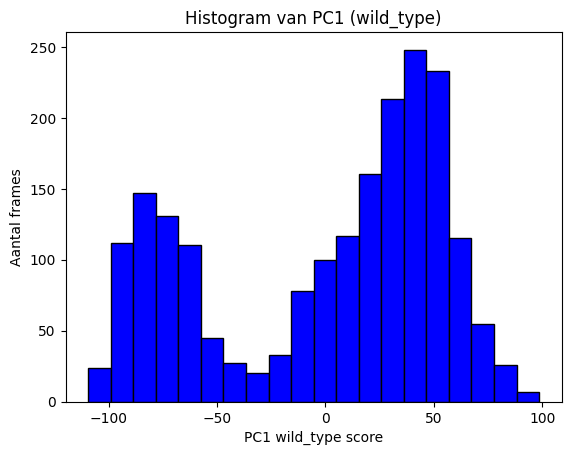

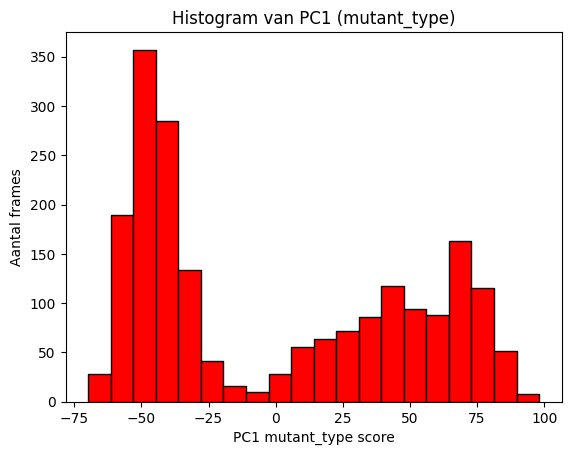

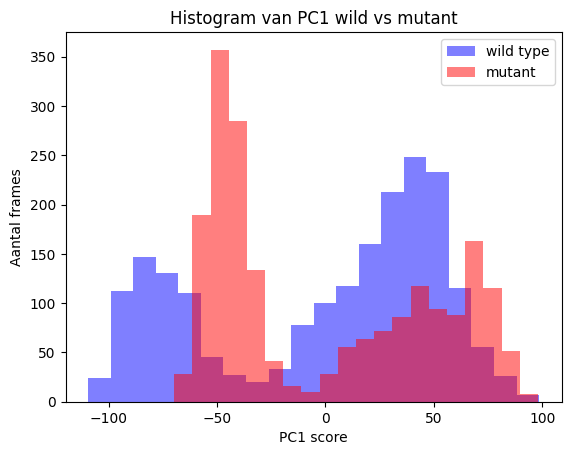

Wild-type mean=  3.636160726728349e-15 std =  54.386588161762006
Mutant-type mean=  3.636160726728349e-15 std =  50.4585491204126


In [6]:
import numpy as np
import matplotlib.pyplot as plt

S1_wild = np.loadtxt("PC1_wildscores.txt")

plt.hist(S1_wild, bins=20, color='blue', edgecolor='black')
plt.xlabel('PC1 wild_type score')
plt.ylabel('Aantal frames')
plt.title("Histogram van PC1 (wild_type)")
plt.show()

S1_mutant = np.loadtxt("PC1_mutantscores.txt")

plt.hist(S1_mutant, bins=20, color='red', edgecolor='black')
plt.xlabel('PC1 mutant_type score')
plt.ylabel('Aantal frames')
plt.title("Histogram van PC1 (mutant_type)")
plt.show()

plt.hist(S1_wild, bins=20, color='blue', alpha=0.5, label='wild type')
plt.hist(S1_mutant, bins=20, color='red', alpha=0.5, label='mutant')
plt.xlabel('PC1 score')
plt.ylabel('Aantal frames')
plt.title("Histogram van PC1 wild vs mutant")
plt.legend()
plt.show()

print("Wild-type mean= ", S1_wild.mean(), "std = ", S1_wild.std())
print("Mutant-type mean= ", S1_mutant.mean(), "std = ", S1_mutant.std())

Vanuit de PCA zijn de PC1-scores opgeslagen en weergegeven in een histogram. PC1 is de hoofdcomponent die de meeste variantie in de data verklaart. Elke balk geeft het aantal frames weer met een bepaalde PC1-score.

De verdelingen van wild type en mutant type verschillen duidelijk. De mutant vertoont een sterke piek bij negatieve PC1-waarden (rond −50), terwijl het wild type relatief meer positieve PC1-scores heeft (ongeveer +25 tot +60). Hoewel er overlap is tussen beide groepen, zijn de verdelingen duidelijk niet identiek.

Hoewel het gemiddelde van de PC1-scores voor wild type en mutant gelijk is (zoals verwacht bij een gecentreerde PCA), verschillen de verdelingen duidelijk in vorm en spreiding. Dit wijst erop dat de belangrijkste variatie-as in de data verschillend wordt benut door beide genotypes. Daarnaast vertoont het wild type een iets grotere spreiding (σ ≈ 54) dan de mutant (σ ≈ 50), wat suggereert dat het wild type meer variatie vertoont langs de eerste hoofdcomponent, terwijl de mutant relatief restrictiever gedrag laat zien.

### Vergelijkende analyse van wild-type en mutant

In PyMOL kun je de RMSF data visualiseren door de RMSF-waarden in te lezen als B-factoren, waardoor je het eiwit kunt kleuren op flexibiliteit (blauw=rigide, rood=flexibel). De mutatie op plek 138 is met geel aangegeven zodat het duidelijk te zien is.

```bash
gmx rmsf -s Manon/A/A-MD.tpr -f MB_A_whole.xtc -o rmsf_wild.xvg -oq bfactor_wild.pdb -res
gmx rmsf -s Manon/B/B-MD.tpr -f MB_B_whole.xtc -o rmsf_mutant.xvg -oq bfactor_mutant.pdb -res
```

```pml
# Laad de wild-type structuur met B-factoren
load bfactor_wild.pdb, wt
# Laad de mutant structuur met B-factoren
load bfactor_mutant.pdb, mut

# Superponeer de 'mut' op de 'wt' op basis van de backbone atomen
super mut, wt, mobile_state=1, target_state=1

# Verberg de standaard weergave en toon als cartoon
hide everything
show cartoon

# Kleur het eiwit op basis van de B-factor (flexibiliteit)
spectrum b, blue_red, wt
spectrum b, blue_red, mut

# Centreer de weergave
zoom all

# Selecteer het specifieke residu 138 in het mutant-object
select mutant_site, mut and resi 138

# Geef deze selectie een opvallende kleur (bijv. fel geel of groen)
color yellow, mutant_site

# Geef dit residu ook een "stick" weergave zodat je de zijketen ziet
show sticks, mutant_site

```

![Pymolbestand3](Pymolbestand3.png)

Blauwe gebieden: De kern van het eiwit en de meeste helices zijn blauw, wat wijst op rigide en stabiele gebieden (lage fluctuatie).
Rode en roze gebieden: De lussen aan de boven- en onderkant van het eiwit zijn rood/roze/paarsig gekleurd. Dit zijn de flexibele gebieden (hoge fluctuatie).
Gele 'stick': Dit is de gemarkeerde mutatieplek, residu 138 (N857S). Valt op dat dit in een blauw gebied valt.

### _Verschil tussen asparagine (N) en serine (S)_

Alles draait hier om de N857S-mutatie in het kinase domein van het ERBB2-eiwit.

Asparagine:
- Amide (-CONH₂) zijketen
- Polair en elektrisch neutraal
- Zorgt voor structurele stabiliteit
- Niet fosforyleerbaar
- Groter en minder flexibel dan serine

Serine:
- Hydroxyl (-OH) zijketen
- Polair en chemisch reactiever
- Geeft meer structurele flexibiliteit
- Potentieel fosforyleerbaar
- Kleiner dan asparagine

ERBB2 is een receptor tyrosine kinase die normaal gesproken tyrosineresiduen fosforyleert en waarvan de activiteit sterk afhankelijk is van conformatie en lokale interacties binnen het kinase domein.

De mutatie van asparagine naar serine kan leiden tot:

- introductie van een potentieel fosforyleerbaar residu
- veranderingen in lokale waterstofbruggen
- verhoogde flexibiliteit van het kinase domein
Deze structurele veranderingen kunnen resulteren in:
- constitutieve activatie van het ERBB2-kinase
- verminderde afhankelijkheid van ligandbinding
- versterkte downstream signaaltransductie

Eierstokcellen zijn bijzonder gevoelig voor veranderingen in kinase-activiteit en zijn sterk afhankelijk van RTK–PI3K–AKT-signaling. Een verhoogde en ongecontroleerde activatie van ERBB2 kan deze signaalroutes versterken, wat bijdraagt aan ongecontroleerde celproliferatie en tumorontwikkeling.

# Conclusie

De resultaten van deze case-studie laten zien dat de N857S-mutatie in het ERBB2-
kinasedomein leidt tot meetbare verschillen in eiwitdynamiek en lokale flexibiliteit
ten opzichte van het wild-type eiwit. De RMSD-analyse bevestigt dit beeld: de structuur van de mutant vertoont grotere fluctuaties gedurende de simulatie, wat duidt op een toegenomen globale instabiliteit of het optreden van subtiele structurele veranderingen.

Hoewel de globale architectuur van het eiwit grotendeels behouden blijft, wijzen de RMSF-profielen op specifieke lokale effecten. In de directe nabijheid van de mutatieregio (residue 857) vertoont de mutant een afwijkende RMSF-waarde, wat duidt op een veranderde lokale flexibiliteit door de substitutie van asparagine naar serine. Buiten dit gebied zijn de RMSF-patronen voor beide eiwitten nagenoeg identiek, wat suggereert dat de functionele impact van de mutatie zich primair toespitst op de lokale dynamiek van het kinasedomein.

Hoewel het gemiddelde van de PC1-scores voor wild type en mutant gelijk is (zoals verwacht bij een gecentreerde PCA), verschillen de verdelingen duidelijk in vorm en spreiding. Dit wijst erop dat de belangrijkste variatie-as in de data verschillend wordt benut door beide genotypes. Daarnaast vertoont het wild type een iets grotere spreiding (σ ≈ 54) dan de mutant (σ ≈ 50), wat suggereert dat het wild type meer variatie vertoont langs de eerste hoofdcomponent, terwijl de mutant relatief restrictiever gedrag laat zien.

Deze bevindingen ondersteunen de hypothese dat de N857S-mutatie via deze verhoogde flexibiliteit kan bijdragen aan oncogene activatie en mogelijk de effectiviteit van bestaande gerichte therapieën beïnvloedt bij eierstokkanker.

## Reflectie en beperkingen
Bij de interpretatie van deze resultaten dienen enkele beperkingen in acht genomen
te worden:

AlphaFold voorspelt een statische eiwitstructuur en houdt geen rekening met
conformationele veranderingen over tijd.

Molecular dynamics simulaties zijn beperkt in tijdschaal (nanoseconden) en kunnen mogelijk
zeldzame, maar biologisch relevante, conformaties missen.

De resultaten zijn gebaseerd op computationele modellen en vereisen experimentele
validatie, bijvoorbeeld via biochemische assays of structurele experimenten.

Ook is de simulatie uitgevoerd op een geïsoleerd domein (kinase domein), in een cellulaire context kunnen interacties met andere eiwitten of het celmembraan de dynamiek beïnvloeden.